In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Load participant info and rename SID to participant_id
participant_info = pd.read_csv('/Users/brucey/Downloads/participant_info.csv')
participant_info = participant_info.rename(columns={'SID': 'participant_id'})

# converting sleep disorders into numerical values
sleep_disorder_mapping = {
    'osa': 0, 'snoring': 1, 'sleep apnea': 2, 'difficulty breathing': 3,
    'snorts': 4, 'snort': 5, 'rls': 6, 'morning headaches': 7,
    'eds': 8, 'bruxism': 9
}

# converting medical history into numerical data
medical_history_mapping = {
    'cad': 10, 'diabetes': 11, 'gerd': 12, 'hypertension': 13,
    'sleep apnea': 14, 'migraine': 15, 'none': 16, 'anxiety': 17,
    'asthma': 18, 'body pain': 19, 'depression': 20, 'arrhythmia': 21
}

# Helper function to encode ALL disorders as a list
def encode_all_disorders(disorder_string, mapping):
    if pd.isnull(disorder_string):
        return np.nan
    disorder_string = disorder_string.replace(';', ',').lower()
    disorders = [d.strip() for d in disorder_string.split(',')]
    codes = [mapping[d] for d in disorders if d in mapping]
    if not codes:
        return np.nan
    if len(codes) == 1:
        return codes[0]  # Single code (not list)
    return codes  # List of codes if multiple

# Mapping the disorders to numeric codes (as lists)
participant_info['Sleep_Disorders_Encoded'] = participant_info['Sleep_Disorders'].apply(
    lambda x: encode_all_disorders(x, sleep_disorder_mapping)
)
# Mapping the medical history to numeric codes (as lists)
participant_info['Medical_History_Encoded'] = participant_info['MEDICAL_HISTORY'].apply(
    lambda x: encode_all_disorders(x, medical_history_mapping)
)

# Ensure the ID is a string (matches the 'S007', etc.)
participant_info['participant_id'] = participant_info['participant_id'].astype(str)

# Load and tag participant data
participants = ['S003', 'S007', 'S012', 'S017', 'S021', 'S026', 'S034', 
                'S039', 'S043', 'S046', 'S053', 'S059', 'S063', 'S069', 
                'S073', 'S079', 'S084', 'S090', 'S097', 'S102']
dfs = []

for pid in participants:
    df = pd.read_csv(f'/Users/brucey/Downloads/{pid}_whole_df.csv')
    df['participant_id'] = pid  # Add ID column for merging
    dfs.append(df)

# Combine all participant sleep data
sleep_data = pd.concat(dfs, ignore_index=True)

# Merge with participant info on participant_id
merged_data = pd.merge(sleep_data, participant_info, on='participant_id', how='left')

# Check results
merged_data.head()


,TIMESTAMP,BVP,ACC_X,ACC_Y,ACC_Z,TEMP,EDA,HR,IBI,Sleep_Stage,...,GENDER,BMI,OAHI,AHI,Mean_SaO2,Arousal Index,MEDICAL_HISTORY,Sleep_Disorders,Sleep_Disorders_Encoded,Medical_History_Encoded
0,0.000000,-47.02,-66.0,-11.0,-11.0,30.71,0.384353,55.0,NaN,P,...,F,51.0,34,37,95%,28,NaN,"snoring, sleep apnea, difficulty breathing, sn...","[1, 2, 3, 4]",NaN
1,0.015625,-54.19,-66.0,-11.0,-11.0,30.71,0.384353,55.0,NaN,P,...,F,51.0,34,37,95%,28,NaN,"snoring, sleep apnea, difficulty breathing, sn...","[1, 2, 3, 4]",NaN
2,0.031250,-59.62,-67.0,-9.0,-11.0,30.71,0.384353,55.0,NaN,P,...,F,51.0,34,37,95%,28,NaN,"snoring, sleep apnea, difficulty breathing, sn...","[1, 2, 3, 4]",NaN
3,0.046875,-61.75,-67.0,-9.0,-11.0,30.71,0.384353,55.0,NaN,P,...,F,51.0,34,37,95%,28,NaN,"snoring, sleep apnea, difficulty breathing, sn...","[1, 2, 3, 4]",NaN
4,0.062500,-60.07,-64.0,-9.0,-6.0,30.71,0.384353,55.0,NaN,P,...,F,51.0,34,37,95%,28,NaN,"snoring, sleep apnea, difficulty breathing, sn...","[1, 2, 3, 4]",NaN


In [7]:
# per-second means of BVP, IBI, HR (since 64 data points per sec) 
# Added a 'second' column 
merged_data['second'] = merged_data.groupby('participant_id').cumcount() // 64

# Aggregate heart-related metrics per participant
# 64 Hz, aggregate per participant

agg_data = merged_data.groupby(['participant_id']).agg({
    'HR': ['mean', 'std'],
    'IBI': ['mean', 'std'],
    'BVP': ['mean', 'std'],
}).reset_index()

# Flatten column names
agg_data.columns = ['participant_id', 'HR_mean', 'HR_std', 'IBI_mean', 'IBI_std', 'BVP_mean', 'BVP_std']

# Merging with participant info
merged_data = pd.merge(
    agg_data, 
    participant_info[['participant_id', 'Sleep_Disorders_Encoded', 'Medical_History_Encoded']],
    on='participant_id', 
    how='left'
)


In [8]:
# Flatten lists in the encoded columns (if any)
merged_data['Sleep_Disorders_Encoded'] = merged_data['Sleep_Disorders_Encoded'].apply(
    lambda x: x[0] if isinstance(x, list) else x  
)

merged_data['Medical_History_Encoded'] = merged_data['Medical_History_Encoded'].apply(
    lambda x: x[0] if isinstance(x, list) else x 
)

merged_data


,participant_id,HR_mean,HR_std,IBI_mean,IBI_std,BVP_mean,BVP_std,Sleep_Disorders_Encoded,Medical_History_Encoded
0,S003,71.043226,12.277283,0.865725,0.133280,0.000487,66.073749,1.0,NaN
1,S007,69.519649,6.825494,0.865082,0.123840,-0.000834,93.196826,0.0,10.0
2,S012,64.934130,6.917661,0.943730,0.099455,-0.000394,85.220072,0.0,18.0
3,S017,64.108700,15.525526,1.219293,0.151550,-0.002241,103.696381,2.0,13.0
4,S021,74.950907,10.027658,0.811468,0.122890,0.000347,78.440250,0.0,21.0
5,S026,64.632223,11.764233,0.754228,0.053710,-0.000266,104.430372,1.0,13.0
6,S034,54.462087,14.515130,1.200814,0.173527,0.000264,82.195400,1.0,15.0
7,S039,61.427603,13.139233,1.025112,0.232038,-0.000087,41.749090,0.0,21.0
8,S043,56.023408,8.594173,1.101824,0.173548,0.000539,63.912143,1.0,19.0
9,S046,104.048342,12.023698,0.443499,0.110179,-0.000167,43.678603,8.0,NaN


In [9]:
# Prepare predictors
predictors = merged_data.drop(columns=['participant_id'])
predictors = predictors.apply(pd.to_numeric, errors='coerce')
predictors = predictors.fillna(predictors.mean())

# List of targets
targets = ['HR_mean', 'HR_std', 'IBI_mean', 'IBI_std', 'BVP_mean', 'BVP_std']


Modeling Target: HR_mean


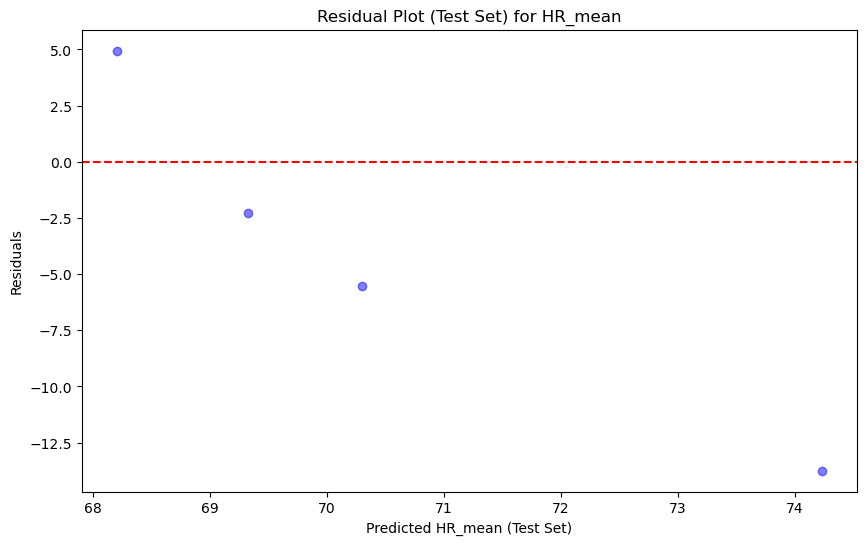

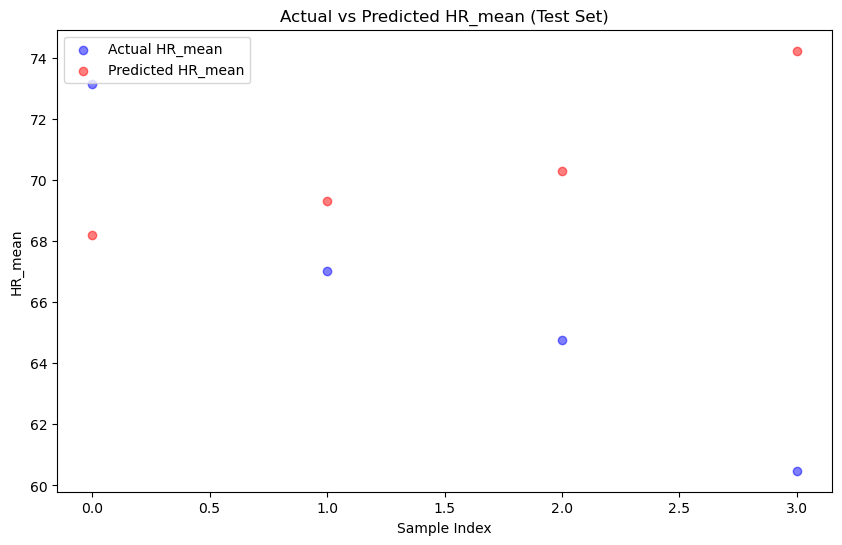

MSE: 62.3368
RMSE: 7.8954
MAE: 6.6296
Intercept: 99.95555656017748

Coefficients DataFrame:
                         Estimated Coefficients
HR_std                                 0.022715
IBI_mean                             -52.474460
IBI_std                               68.836368
BVP_mean                            -870.917259
BVP_std                                0.067660
Sleep_Disorders_Encoded                1.863061
Medical_History_Encoded               -0.053393

Regression Equation:
y = 99.9556 + (0.0227 × HR_std) + (-52.4745 × IBI_mean) + (68.8364 × IBI_std) + (-870.9173 × BVP_mean) + (0.0677 × BVP_std) + (1.8631 × Sleep_Disorders_Encoded) + (-0.0534 × Medical_History_Encoded)

Sample Predictions (Test Set):
[68.20483305 69.32330542 70.29994202 74.23072475]

Modeling Target: HR_std


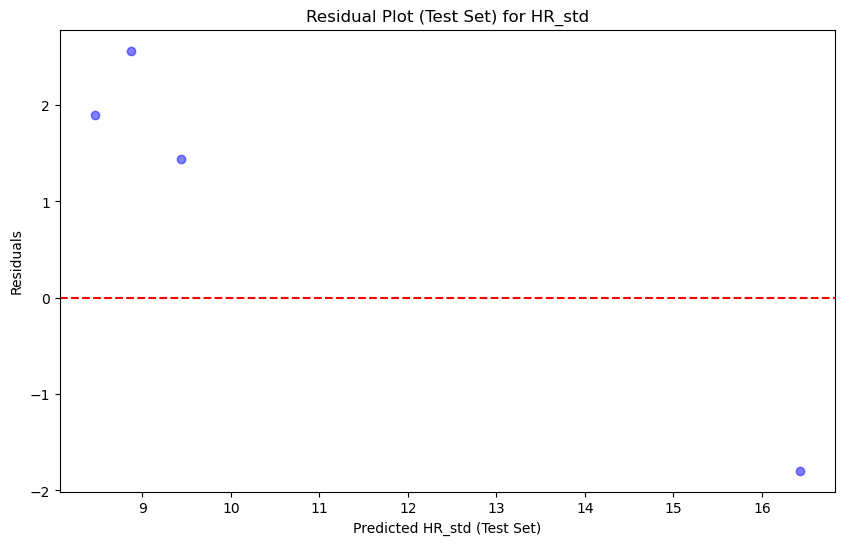

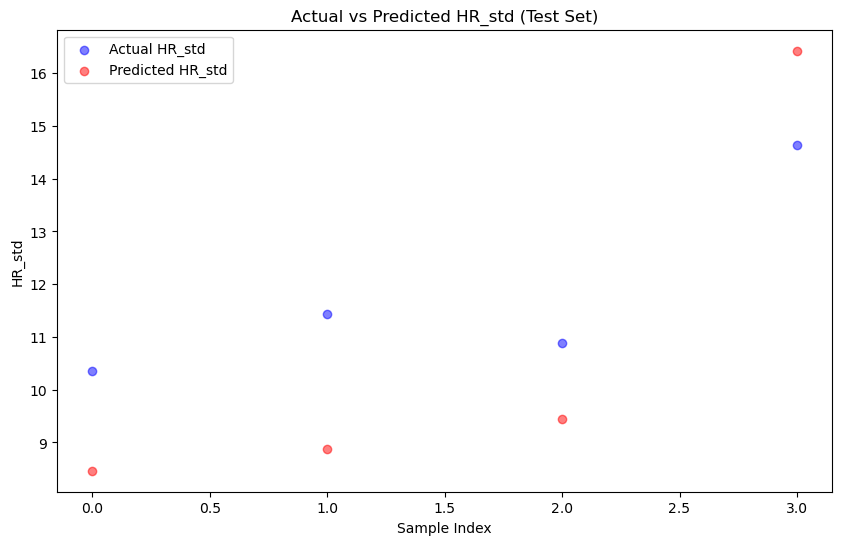

MSE: 3.8592
RMSE: 1.9645
MAE: 1.9219
Intercept: 0.6695467759361531

Coefficients DataFrame:
                         Estimated Coefficients
HR_mean                                0.008870
IBI_mean                              -0.215422
IBI_std                               53.072645
BVP_mean                            -130.924083
BVP_std                                0.042701
Sleep_Disorders_Encoded                0.366852
Medical_History_Encoded               -0.103317

Regression Equation:
y = 0.6695 + (0.0089 × HR_mean) + (-0.2154 × IBI_mean) + (53.0726 × IBI_std) + (-130.9241 × BVP_mean) + (0.0427 × BVP_std) + (0.3669 × Sleep_Disorders_Encoded) + (-0.1033 × Medical_History_Encoded)

Sample Predictions (Test Set):
[ 8.46451051  8.87477165  9.43972133 16.4249957 ]

Modeling Target: IBI_mean


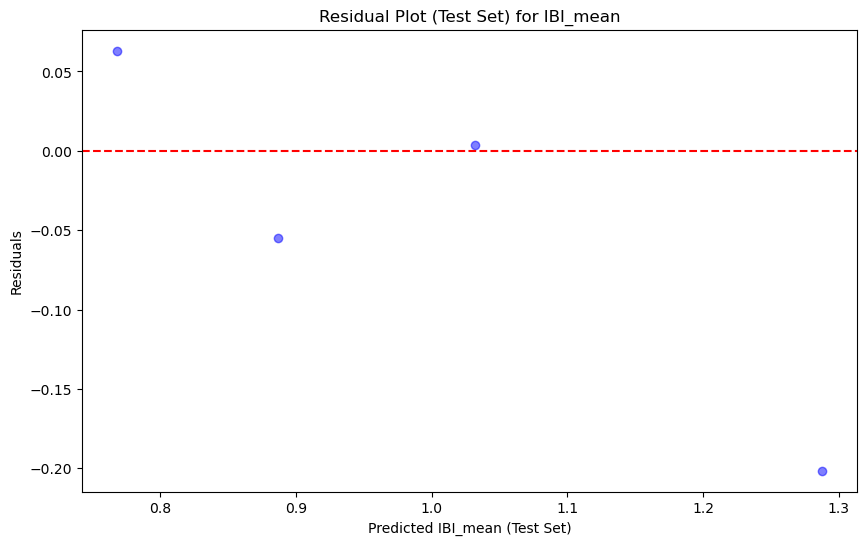

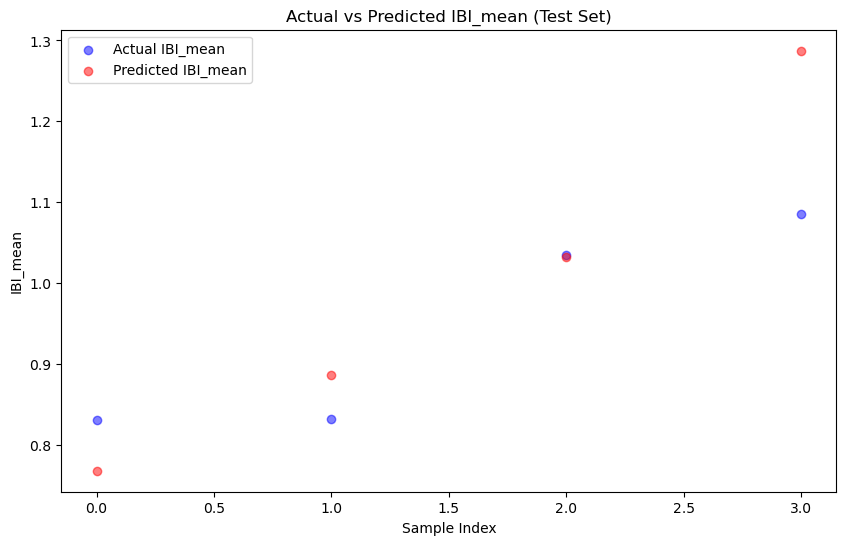

MSE: 0.0119
RMSE: 0.1091
MAE: 0.0807
Intercept: 1.5353778746918254

Coefficients DataFrame:
                         Estimated Coefficients
HR_mean                               -0.014385
HR_std                                -0.000151
IBI_std                                1.610333
BVP_mean                             -18.688504
BVP_std                                0.001642
Sleep_Disorders_Encoded                0.024355
Medical_History_Encoded               -0.000604

Regression Equation:
y = 1.5354 + (-0.0144 × HR_mean) + (-0.0002 × HR_std) + (1.6103 × IBI_std) + (-18.6885 × BVP_mean) + (0.0016 × BVP_std) + (0.0244 × Sleep_Disorders_Encoded) + (-0.0006 × Medical_History_Encoded)

Sample Predictions (Test Set):
[0.76848101 0.88677451 1.03193236 1.28727535]

Modeling Target: IBI_std


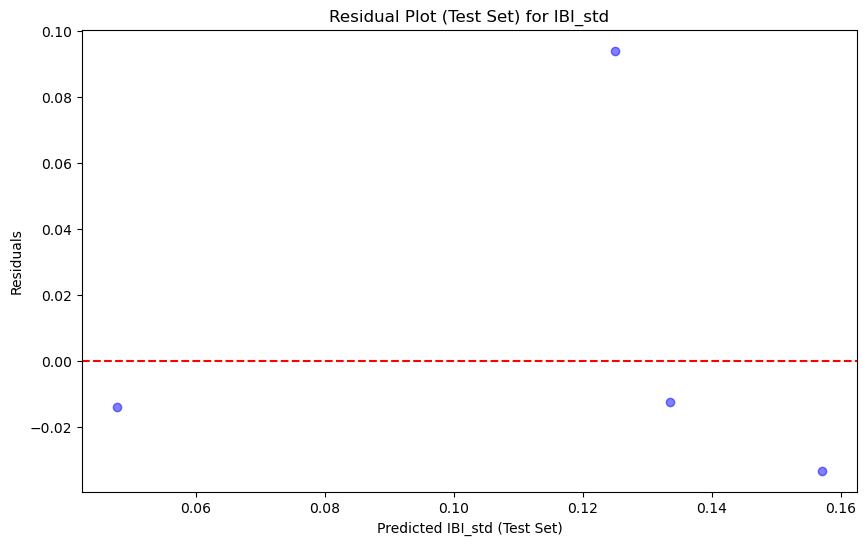

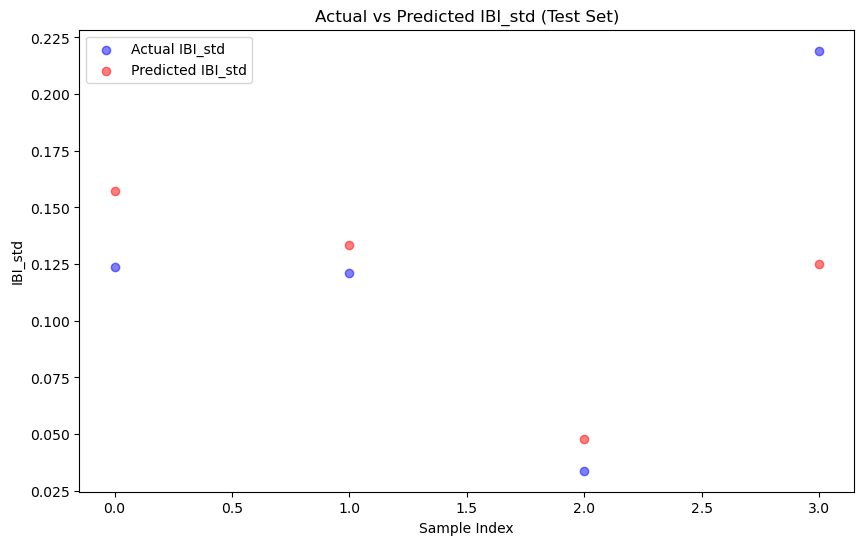

MSE: 0.0026
RMSE: 0.0508
MAE: 0.0385
Intercept: -0.2308713427965258

Coefficients DataFrame:
                         Estimated Coefficients
HR_mean                                0.002485
HR_std                                 0.004906
IBI_mean                               0.212035
BVP_mean                               2.360619
BVP_std                               -0.000874
Sleep_Disorders_Encoded               -0.009572
Medical_History_Encoded                0.001795

Regression Equation:
y = -0.2309 + (0.0025 × HR_mean) + (0.0049 × HR_std) + (0.2120 × IBI_mean) + (2.3606 × BVP_mean) + (-0.0009 × BVP_std) + (-0.0096 × Sleep_Disorders_Encoded) + (0.0018 × Medical_History_Encoded)

Sample Predictions (Test Set):
[0.15704621 0.1335859  0.04781109 0.12504406]

Modeling Target: BVP_mean


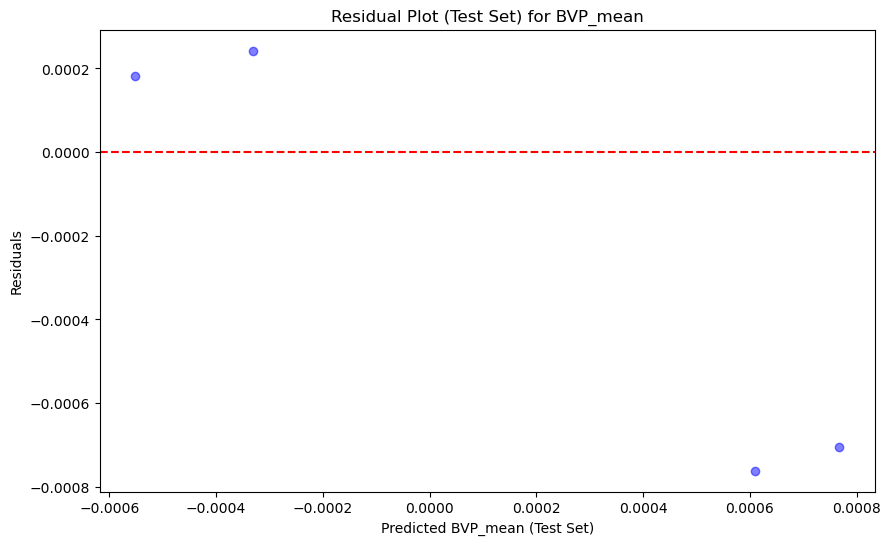

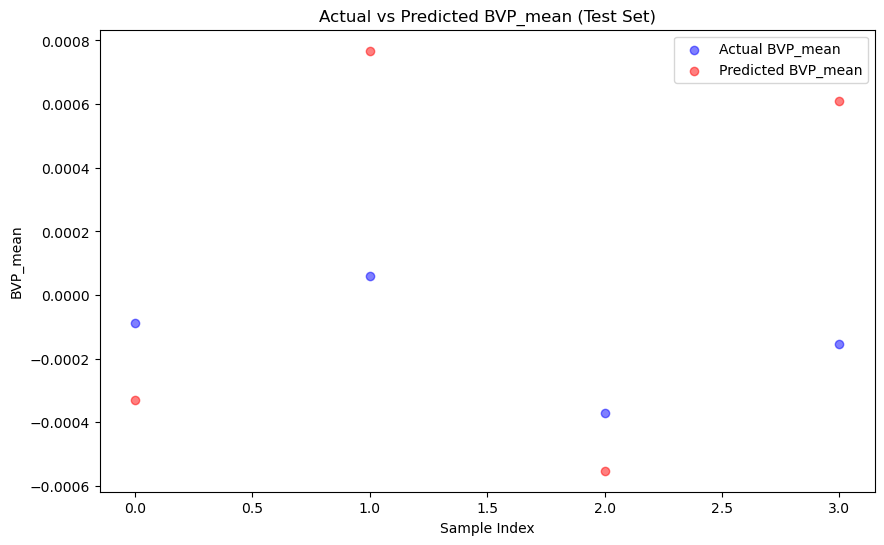

MSE: 0.0000
RMSE: 0.0005
MAE: 0.0005
Intercept: 0.0045238339595267485

Coefficients DataFrame:
                         Estimated Coefficients
HR_mean                               -0.000058
HR_std                                -0.000022
IBI_mean                              -0.004503
IBI_std                                0.004319
BVP_std                                0.000012
Sleep_Disorders_Encoded                0.000107
Medical_History_Encoded                0.000123

Regression Equation:
y = 0.0045 + (-0.0001 × HR_mean) + (-0.0000 × HR_std) + (-0.0045 × IBI_mean) + (0.0043 × IBI_std) + (0.0000 × BVP_std) + (0.0001 × Sleep_Disorders_Encoded) + (0.0001 × Medical_History_Encoded)

Sample Predictions (Test Set):
[-0.00033029  0.00076779 -0.00055199  0.00060874]

Modeling Target: BVP_std


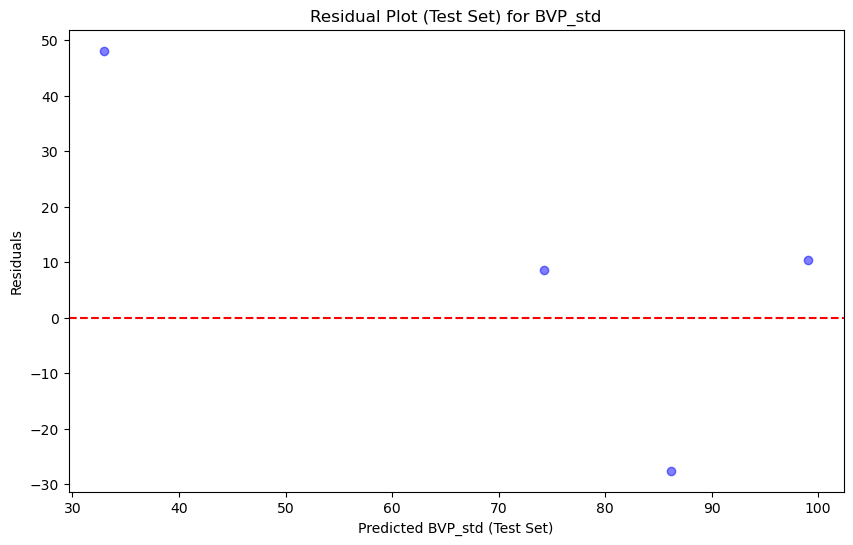

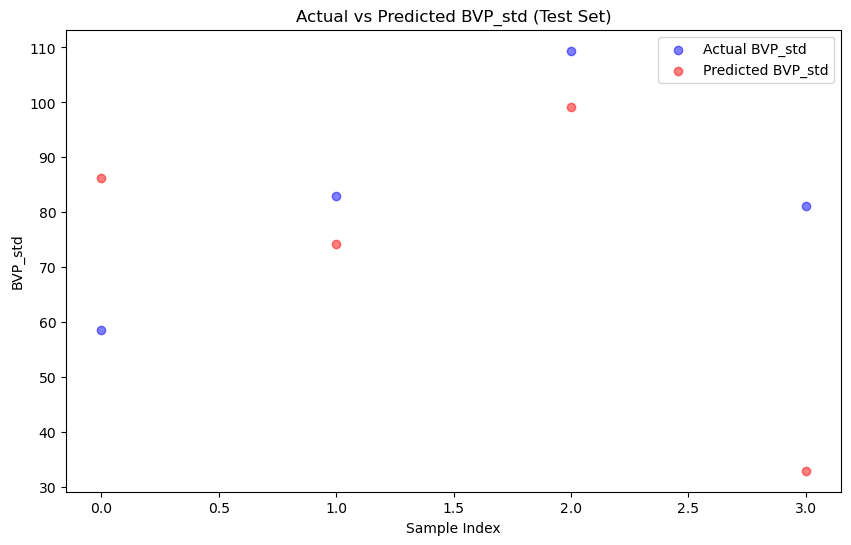

MSE: 814.4531
RMSE: 28.5386
MAE: 23.6722
Intercept: 5.799308640652271

Coefficients DataFrame:
                         Estimated Coefficients
HR_mean                                0.997090
HR_std                                 1.611459
IBI_mean                              88.270813
IBI_std                             -356.879275
BVP_mean                            2694.738294
Sleep_Disorders_Encoded               -5.579849
Medical_History_Encoded               -2.249382

Regression Equation:
y = 5.7993 + (0.9971 × HR_mean) + (1.6115 × HR_std) + (88.2708 × IBI_mean) + (-356.8793 × IBI_std) + (2694.7383 × BVP_mean) + (-5.5798 × Sleep_Disorders_Encoded) + (-2.2494 × Medical_History_Encoded)

Sample Predictions (Test Set):
[86.2066319  74.22414342 99.08918959 32.94647952]


In [10]:
for target in targets:
    print(f"\n{'=' * 40}\nModeling Target: {target}\n{'=' * 40}")
    
    X = predictors.drop(columns=[target])
    y = predictors[target]
    
    # Manual split
    split_index = int(len(X) * 0.8)
    X_train = X[:split_index]
    X_test = X[split_index:]
    y_train = y[:split_index]
    y_test = y[split_index:]
    
    # Model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Residual Plot (Test Set)
    residuals = y_test - y_pred_test
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred_test, residuals, color='blue', alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel(f'Predicted {target} (Test Set)')
    plt.ylabel('Residuals')
    plt.title(f'Residual Plot (Test Set) for {target}')
    plt.show()
    
    # Actual vs Predicted (Test Set)
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(y_test)), y_test, color='blue', alpha=0.5, label=f'Actual {target}')
    plt.scatter(range(len(y_pred_test)), y_pred_test, color='red', alpha=0.5, label=f'Predicted {target}')
    plt.xlabel('Sample Index')
    plt.ylabel(target)
    plt.title(f'Actual vs Predicted {target} (Test Set)')
    plt.legend()
    plt.show()
    
    # Metrics
    n = X_test.shape[0]
    p = X_test.shape[1]
    mse = mean_squared_error(y_test, y_pred_test)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred_test)
    
    print(f'MSE: {mse:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'MAE: {mae:.4f}')
    
    # Coefficients
    print("Intercept:", model.intercept_)
    coef_df = pd.DataFrame(model.coef_, index=X_train.columns, columns=['Estimated Coefficients'])
    print("\nCoefficients DataFrame:")
    print(coef_df)
    
    # Regression Equation
    intercept = model.intercept_
    coefficients = model.coef_
    features = X_train.columns

    equation = f"y = {intercept:.4f}"
    for coef, feature in zip(coefficients, features):
        equation += f" + ({coef:.4f} × {feature})"
    print("\nRegression Equation:")
    print(equation)
    
    # Sample Predictions
    print("\nSample Predictions (Test Set):")
    print(y_pred_test[:5])